In [37]:
# Cell: Imports & Constants
import os, glob, numpy as np, torch, librosa
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import soundfile as sf
import pandas as pd

# must match your preprocess paths
DEN_DIR = '/home/jovyan/Features/denoised'
EMB_DIR = '/home/jovyan/Features/embeddings'
MEL_DIR = '/home/jovyan/Features/mel'

PANNS_SR      = 32000
N_FFT         = 2048
HOP_LENGTH    = 512
N_MELS        = 128
ALPHA         = 0.5


In [29]:
def create_augmented_mel(log_mel, emb, alpha=ALPHA):
    """
    log_mel: np.array shape (n_mels, T)
    emb:     np.array shape (embed_dim,)
    """
    n_mels, T    = log_mel.shape
    embed_dim    = emb.shape[0]

    if embed_dim == n_mels:
        proj = emb
    elif embed_dim > n_mels:
        factor = embed_dim // n_mels
        if embed_dim % n_mels == 0:
            proj = emb.reshape(n_mels, factor).mean(axis=1)
        else:
            proj = emb[:n_mels]
    else:
        proj = np.pad(emb, (0, n_mels - embed_dim))

    tiled = np.tile(proj[:, None], (1, T))
    normed = StandardScaler().fit_transform(tiled.T).T
    return log_mel + alpha * normed

In [34]:
# 1) Denoised WAV Dataset (from manifest.csv)
class DenoisedWavDataset(Dataset):
    def __init__(self, den_dir, target_sr=PANNS_SR):
        manifest = pd.read_csv(os.path.join(den_dir, 'manifest.csv'))
        self.den_dir   = den_dir
        self.paths     = manifest['audio_path'].str.lstrip('/').tolist()
        self.labels    = manifest['primary_label'].tolist()
        self.target_sr = target_sr

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        rel      = self.paths[idx]
        label    = self.labels[idx]
        full     = os.path.join(self.den_dir, rel)
        y, sr0   = sf.read(full, dtype='float32')
        if sr0 != self.target_sr:
            y = librosa.resample(y, orig_sr=sr0, target_sr=self.target_sr)
        return torch.from_numpy(y).float(), label


# 2) Mel‑Spectrogram Dataset (from manifest.csv)
class MelDataset(Dataset):
    def __init__(self, mel_dir):
        manifest = pd.read_csv(os.path.join(mel_dir, 'manifest.csv'))
        self.mel_dir = mel_dir
        self.paths   = manifest['mel_path'].str.lstrip('/').tolist()
        self.labels  = manifest['primary_label'].tolist()

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        rel    = self.paths[idx]
        label  = self.labels[idx]
        full   = os.path.join(self.mel_dir, rel)
        data   = np.load(full)
        mel    = data['mel']
        return torch.from_numpy(mel).float(), label


# 3) PANNs Embedding Dataset (from manifest.csv)
class EmbeddingDataset(Dataset):
    def __init__(self, emb_dir):
        manifest = pd.read_csv(os.path.join(emb_dir, 'manifest.csv'))
        self.emb_dir = emb_dir
        self.paths   = manifest['emb_path'].str.lstrip('/').tolist()
        self.labels  = manifest['primary_label'].tolist()

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        rel    = self.paths[idx]
        label  = self.labels[idx]
        full   = os.path.join(self.emb_dir, rel)
        data   = np.load(full)
        emb    = data['embedding']
        return torch.from_numpy(emb).float(), label


# 4) Augmented Mel Dataset (matches mel → emb by chunk_id from manifest)
class AugmentedMelDataset(Dataset):
    def __init__(self, mel_dir, emb_dir):
        mel_manifest = pd.read_csv(os.path.join(mel_dir, 'manifest.csv'))
        emb_manifest = pd.read_csv(os.path.join(emb_dir, 'manifest.csv'))
        self.mel_dir  = mel_dir
        self.emb_dir  = emb_dir
        self.chunks   = mel_manifest['chunk_id'].tolist()
        self.mel_map  = dict(zip(mel_manifest['chunk_id'],
                                 mel_manifest['mel_path'].str.lstrip('/')))
        self.emb_map  = dict(zip(emb_manifest['chunk_id'],
                                 emb_manifest['emb_path'].str.lstrip('/')))
        self.labels   = mel_manifest['primary_label'].tolist()

    def __len__(self):
        return len(self.chunks)

    def __getitem__(self, idx):
        cid     = self.chunks[idx]
        label   = self.labels[idx]

        # load mel
        mel_rel = self.mel_map[cid]
        mel_full= os.path.join(self.mel_dir, mel_rel)
        mdata   = np.load(mel_full)
        log_mel = mdata['mel']

        # load emb
        emb_rel = self.emb_map[cid]
        emb_full= os.path.join(self.emb_dir, emb_rel)
        edata   = np.load(emb_full)
        emb     = edata['embedding']

        # augment
        aug = create_augmented_mel(log_mel, emb)
        return torch.from_numpy(aug).float(), label

In [35]:
def collate_fn(batch):
    xs, ys = zip(*batch)
    xs = torch.stack(xs)
    return xs, list(ys)

In [42]:
BATCH_SIZE = 64
den_loader = DataLoader(
    DenoisedWavDataset(DEN_DIR, target_sr=PANNS_SR),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    collate_fn=collate_fn
)

mel_loader = DataLoader(
    MelDataset(MEL_DIR),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    collate_fn=collate_fn
)

emb_loader = DataLoader(
    EmbeddingDataset(EMB_DIR),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    collate_fn=collate_fn
)

aug_dataset = AugmentedMelDataset(MEL_DIR, EMB_DIR)
aug_loader  = DataLoader(
    aug_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    collate_fn=collate_fn
)


In [43]:
loaders = {
    'denoised':     den_loader,
    'mel_spectro':  mel_loader,
    'embeddings':   emb_loader,
    'augmentedMel': aug_loader
}
NUM_BATCHES = 5

for name, loader in loaders.items():
    t0 = time.time()
    for i, (x, y) in enumerate(loader):
        if i+1 >= NUM_BATCHES:
            break
    t1 = time.time()
    total = t1 - t0
    print(f"{name:12s}: {i+1} batches in {total:.3f}s, avg {total/(i+1):.3f}s/batch")

denoised    : 5 batches in 2.033s, avg 0.407s/batch
mel_spectro : 5 batches in 0.324s, avg 0.065s/batch
embeddings  : 5 batches in 0.246s, avg 0.049s/batch
augmentedMel: 5 batches in 0.510s, avg 0.102s/batch


▶️ Denoised Audio Sample — label: strfly1


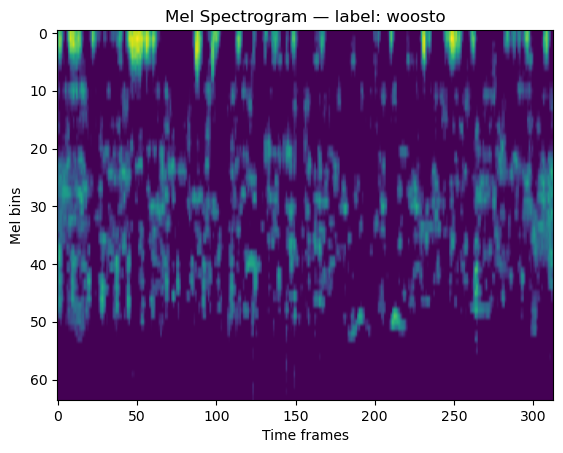

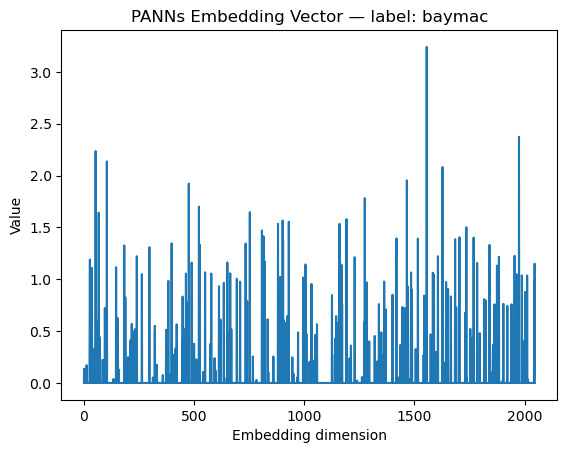

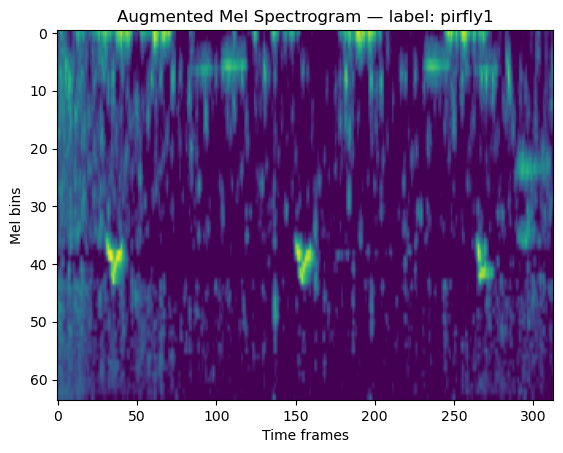

In [33]:
from IPython.display import Audio, display
import matplotlib.pyplot as plt

# 1) Denoised audio: play one chunk
waves, labels = next(iter(den_loader))
wave_np = waves[0].numpy()           # [CHUNK_SAMPLES]
print("▶️ Denoised Audio Sample — label:", labels[0])
display(Audio(wave_np, rate=PANNS_SR))

# 2) Mel spectrogram: visualize one chunk
mels, labels = next(iter(mel_loader))
mel = mels[0].numpy()                # [n_mels, T]
plt.figure()
plt.imshow(mel, aspect='auto')
plt.title(f"Mel Spectrogram — label: {labels[0]}")
plt.xlabel("Time frames")
plt.ylabel("Mel bins")
plt.show()

# 3) PANNs embeddings: plot one vector
embs, labels = next(iter(emb_loader))
emb = embs[0].numpy()                # [embed_dim]
plt.figure()
plt.plot(emb)
plt.title(f"PANNs Embedding Vector — label: {labels[0]}")
plt.xlabel("Embedding dimension")
plt.ylabel("Value")
plt.show()

# 4) Augmented Mel: visualize one augmented mel
augs, labels = next(iter(aug_loader))
aug = augs[0].numpy()                # [n_mels, T]
plt.figure()
plt.imshow(aug, aspect='auto')
plt.title(f"Augmented Mel Spectrogram — label: {labels[0]}")
plt.xlabel("Time frames")
plt.ylabel("Mel bins")
plt.show()
